# Instrument Recognition Based on Deep CNN

## Import Librarys

In [1]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

## Audio Preprocessing

*Here we processed the original audio to get both mel-spectrogram as well as other features.*


In [2]:
import os
import numpy as np
import librosa

# Function to preprocess audio and compute mel-spectrogram and additional features
def preprocess_audio(file_path,
                    target_sr=22050,
                    n_fft=1024,
                    hop_length=512,
                    n_mels=128,
                    max_length=3.0):
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=target_sr, mono=True)

        # Normalize the audio signal
        if np.max(np.abs(y)) > 0:
            y = y / np.max(np.abs(y))

        # Ensure consistency in audio length
        max_length_samples = int(target_sr * max_length)
        if len(y) > max_length_samples:
            y = y[:max_length_samples]
        else:
            pad_width = max_length_samples - len(y)
            y = np.pad(y, (0, pad_width), mode='constant')

        # Compute Mel-Spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(
            y=y,
            sr=target_sr,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels,
            fmax=target_sr / 2
        )

        # Apply natural logarithm
        log_mel_spectrogram = np.log(mel_spectrogram + 1e-9)  # Add epsilon to avoid log(0)

        # Extract Additional Features
        rms = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)

        # Aggregate additional features
        # Compute mean and variance for each feature
        rms_mean = np.mean(rms, axis=1)
        rms_var = np.var(rms, axis=1)

        spec_cent_mean = np.mean(spec_cent, axis=1)
        spec_cent_var = np.var(spec_cent, axis=1)

        spec_bw_mean = np.mean(spec_bw, axis=1)
        spec_bw_var = np.var(spec_bw, axis=1)

        rolloff_mean = np.mean(rolloff, axis=1)
        rolloff_var = np.var(rolloff, axis=1)

        zcr_mean = np.mean(zcr, axis=1)
        zcr_var = np.var(zcr, axis=1)

        # Concatenate all aggregated features into a single feature vector
        additional_features = np.concatenate([
            rms_mean,
            rms_var,
            spec_cent_mean,
            spec_cent_var,
            spec_bw_mean,
            spec_bw_var,
            rolloff_mean,
            rolloff_var,
            zcr_mean,
            zcr_var
        ])

        return log_mel_spectrogram, additional_features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None
    
def save_features(mel_spec, additional_features, save_path_mel, save_path_feat):
    """
    Saves the Mel-spectrogram and additional features as separate .npy files.

    Parameters:
    - mel_spec (np.ndarray): The log Mel-spectrogram.
    - additional_features (np.ndarray): The aggregated additional features.
    - save_path_mel (str): File path to save the Mel-spectrogram.
    - save_path_feat (str): File path to save the additional features.
    """
    # Create directories if they don't exist
    os.makedirs(os.path.dirname(save_path_mel), exist_ok=True)
    os.makedirs(os.path.dirname(save_path_feat), exist_ok=True)

    # Save the Mel-spectrogram
    np.save(save_path_mel, mel_spec)

    # Save the additional features
    np.save(save_path_feat, additional_features)
    
def process_dataset(data_dirs, save_dir_mel, save_dir_feat, max_length=3.0):
    """
    Processes all .wav files in the specified directories, extracts features, and saves them.

    Parameters:
    - data_dirs (list of str): List of directories containing audio data.
    - save_dir_mel (str): Root directory to save Mel-spectrograms.
    - save_dir_feat (str): Root directory to save additional features.
    - max_length (float): Maximum length of audio in seconds.
    """
    for data_dir in data_dirs:
        for root, _, files in os.walk(data_dir):
            for file in files:
                if file.endswith('.wav'):
                    file_path = os.path.join(root, file)
                    relative_path = os.path.relpath(file_path, data_dir)

                    # Define save paths for Mel-spectrogram and additional features
                    # For Mel-spectrogram
                    save_path_mel = os.path.join(save_dir_mel, relative_path) + '.npy'
                    # For Additional Features
                    save_path_feat = os.path.join(save_dir_feat, relative_path) + '_features.npy'

                    # Skip processing if both files already exist
                    if os.path.exists(save_path_mel) and os.path.exists(save_path_feat):
                        print(f"Already processed: {file_path}")
                        continue

                    # Preprocess audio and extract features
                    mel_spec, additional_features = preprocess_audio(file_path, max_length=max_length)

                    if mel_spec is not None and additional_features is not None:
                        # Save the extracted features
                        save_features(mel_spec, additional_features, save_path_mel, save_path_feat)
                        print(f"Processed and saved: {save_path_mel} and {save_path_feat}")
                    else:
                        print(f"Failed to process {file_path}")
                        
if __name__ == '__main__':
    # Define source directories
    train_dir = "./../../../IRMAS/IRMAS-TrainingData"
    test_dir_part1 = "./../../../IRMAS/IRMAS-TestingData-Part1/Part1"
    test_dir_part2 = "./../../../IRMAS/IRMAS-TestingData-Part2/IRTestingData-Part2"

    # List of data directories to process
    data_dirs = [train_dir, test_dir_part1, test_dir_part2]

    # Define directories to save the precomputed features
    save_dir_mel = './preprocessed_data_mel_spectrogram'
    save_dir_feat = './preprocessed_data_additional_features'

    # Process the dataset
    process_dataset(data_dirs, save_dir_mel, save_dir_feat)

Processed and saved: ./preprocessed_data_mel_spectrogram/gac/[gac][pop_roc]0687__2.wav.npy and ./preprocessed_data_additional_features/gac/[gac][pop_roc]0687__2.wav_features.npy
Processed and saved: ./preprocessed_data_mel_spectrogram/gac/[gac][pop_roc]0721__2.wav.npy and ./preprocessed_data_additional_features/gac/[gac][pop_roc]0721__2.wav_features.npy
Processed and saved: ./preprocessed_data_mel_spectrogram/gac/176__[gac][nod][cou_fol]0772__1.wav.npy and ./preprocessed_data_additional_features/gac/176__[gac][nod][cou_fol]0772__1.wav_features.npy
Processed and saved: ./preprocessed_data_mel_spectrogram/gac/[gac][pop_roc]0642__3.wav.npy and ./preprocessed_data_additional_features/gac/[gac][pop_roc]0642__3.wav_features.npy
Processed and saved: ./preprocessed_data_mel_spectrogram/gac/054__[gac][dru][cou_fol]0763__1.wav.npy and ./preprocessed_data_additional_features/gac/054__[gac][dru][cou_fol]0763__1.wav_features.npy
Processed and saved: ./preprocessed_data_mel_spectrogram/gac/[gac][pop

## Training and Testing Data Process
### Loading Dataset and Create Dataloader

In [15]:
import os
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import random
import pickle
import logging

# -------------------------------
# 1. Setup and Configuration
# -------------------------------

# Set seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    # For deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Configure logging
logging.basicConfig(
    filename='data_loading.log',
    filemode='a',
    format='%(asctime)s - %(levelname)s - %(message)s',
    level=logging.INFO
)

# -------------------------------
# 2. Label Cleaning Function
# -------------------------------

def clean_labels(label_text):
    """
    Cleans and splits raw label text from .txt files.
    Handles artifacts like tabs, newlines, and extra spaces.
    """
    labels = [label.strip() for label in label_text.split() if label.strip()]
    # Remove any numeric-only labels or unexpected characters
    labels = [label for label in labels if not label.isdigit()]
    return labels

# -------------------------------
# 3. Custom Dataset Class
# -------------------------------

class IRMASDataset(Dataset):
    def __init__(self, file_paths, labels, label_encoder, mel_specs_dir,
                 additional_features_dir, scaler,
                 max_length=3.0,
                 segment_length=1.0,
                 transform=None):
        """
        Custom PyTorch Dataset for IRMAS data with precomputed mel-spectrograms and additional features.

        Args:
            file_paths (list): List of audio file paths.
            labels (list): List of labels (list of instruments) for each file.
            label_encoder (LabelEncoder): Fitted LabelEncoder.
            mel_specs_dir (str): Directory where precomputed mel-spectrograms are stored.
            additional_features_dir (str): Directory where additional features are stored.
            scaler (StandardScaler): Fitted scaler for additional features.
            max_length (float): Maximum audio length in seconds.
            segment_length (float): Length of each segment in seconds.
            transform (callable): Transform to apply to mel-spectrogram.
        """
        self.file_paths = file_paths
        self.labels = labels  # List of lists of instrument labels
        self.label_encoder = label_encoder
        self.mel_specs_dir = mel_specs_dir
        self.additional_features_dir = additional_features_dir
        self.scaler = scaler
        self.max_length = max_length
        self.segment_length = segment_length
        self.transform = transform

        self.num_segments = int(self.max_length / self.segment_length)

        # Create a mapping from audio file paths to mel-spectrogram and additional features paths
        self.mel_spec_paths = [self.get_mel_spec_path(fp) for fp in self.file_paths]
        self.additional_feat_paths = [self.get_additional_feat_path(fp) for fp in self.file_paths]

    def get_mel_spec_path(self, audio_path):
        # Get the relative path from the data directory
        relative_path = os.path.relpath(audio_path, start=os.path.commonpath(self.file_paths))
        # Construct the path to the mel-spectrogram
        mel_spec_path = os.path.join(self.mel_specs_dir, relative_path) + '.npy'
        return mel_spec_path

    def get_additional_feat_path(self, audio_path):
        # Get the relative path from the data directory
        relative_path = os.path.relpath(audio_path, start=os.path.commonpath(self.file_paths))
        # Construct the path to the additional features
        additional_feat_path = os.path.join(self.additional_features_dir, relative_path) + '_features.npy'
        return additional_feat_path

    def preprocess_additional_features(self, additional_features):
        """
        Applies scaling to the additional features if a scaler is provided.

        Args:
            additional_features (np.ndarray): Raw additional features.

        Returns:
            np.ndarray: Scaled additional features.
        """
        if self.scaler:
            additional_features = self.scaler.transform(additional_features.reshape(1, -1)).flatten()
        return additional_features

    def __len__(self):
        return len(self.file_paths) * self.num_segments

    def __getitem__(self, idx):
        # Determine which file and segment this index corresponds to
        file_idx = idx // self.num_segments
        segment_idx = idx % self.num_segments

        mel_spec_path = self.mel_spec_paths[file_idx]
        additional_feat_path = self.additional_feat_paths[file_idx]
        labels = self.labels[file_idx]  # List of instrument labels for the file

        # Load precomputed mel-spectrogram
        if os.path.exists(mel_spec_path):
            mel_spec = np.load(mel_spec_path)
        else:
            # Handle missing mel-spectrogram files
            logging.warning(f"Mel-spectrogram not found at {mel_spec_path}. Using zeros.")
            mel_spec = np.zeros((128, int(self.max_length * 22050 / 512) + 1))

        mel_spec = torch.tensor(mel_spec, dtype=torch.float32).unsqueeze(0)  # Shape: [1, 128, time_frames]

        # Load additional features
        if os.path.exists(additional_feat_path):
            additional_features = np.load(additional_feat_path)
        else:
            # Handle missing additional features files
            logging.warning(f"Additional features not found at {additional_feat_path}. Using zeros.")
            additional_features = np.zeros(10)  # Assuming 10 additional features (mean and var for 5)

        # Apply scaling if scaler is provided
        additional_features = self.preprocess_additional_features(additional_features)

        additional_features = torch.tensor(additional_features, dtype=torch.float32)  # Shape: [10]

        # Calculate segment parameters
        total_frames = mel_spec.shape[2]
        frames_per_segment = total_frames // self.num_segments

        start_frame = segment_idx * frames_per_segment
        end_frame = start_frame + frames_per_segment
        segment = mel_spec[:, :, start_frame:end_frame]  # Shape: [1, 128, frames_per_segment]

        # Handle any leftover frames by padding
        if segment.shape[2] < frames_per_segment:
            pad_amount = frames_per_segment - segment.shape[2]
            segment = F.pad(segment, (0, pad_amount), "constant", 0)

        # Apply any transformations
        if self.transform:
            segment = self.transform(segment)

        # Convert labels to multi-hot encoding
        label_indices = self.label_encoder.transform(labels)
        target = torch.zeros(len(self.label_encoder.classes_), dtype=torch.float32)
        target[label_indices] = 1.0

        return (segment, additional_features), target

# -------------------------------
# 4. Metadata Extraction Function
# -------------------------------

def get_metadata(train_dir, test_dir_part1, test_dir_part2):
    """
    Collects file paths and labels from training and testing directories.

    Returns:
        train_file_paths (list): List of training audio file paths.
        train_labels (list): List of label lists for training data.
        test_file_paths (list): List of testing audio file paths.
        test_labels (list): List of label lists for testing data.
    """
    train_file_paths = []
    train_labels = []
    test_file_paths = []
    test_labels = []

    # Process Training Data
    for subdir in os.listdir(train_dir):
        subfolder_path = os.path.join(train_dir, subdir)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                if file.endswith(".wav"):
                    file_path = os.path.join(subfolder_path, file)
                    train_file_paths.append(file_path)
                    train_labels.append([subdir])  # Subfolder name as label list

    # Process Testing Data Part 1 and Part 2
    for test_dir in [test_dir_part1, test_dir_part2]:
        if not os.path.exists(test_dir):
            continue
        for file in os.listdir(test_dir):
            if file.endswith(".wav"):
                file_path = os.path.join(test_dir, file)
                txt_file_path = os.path.splitext(file_path)[0] + ".txt"
                test_file_paths.append(file_path)

                # Read the labels from the .txt file
                if os.path.exists(txt_file_path):
                    with open(txt_file_path, "r") as txt_file:
                        raw_labels = txt_file.read()
                        labels = clean_labels(raw_labels)
                        test_labels.append(labels)
                else:
                    # Handle missing label files
                    test_labels.append([])  # Assign empty list instead of ["unknown"]

    return train_file_paths, train_labels, test_file_paths, test_labels

# -------------------------------
# 5. Label Encoding and Scaler
# -------------------------------

def fit_scaler(additional_features_dir, train_file_paths):
    """
    Fits a StandardScaler on the additional features from the training set.

    Args:
        additional_features_dir (str): Directory containing additional features.
        train_file_paths (list): List of training audio file paths.

    Returns:
        scaler (StandardScaler): Fitted scaler object.
    """
    all_additional_features = []
    for fp in tqdm(train_file_paths, desc="Fitting scaler on additional features"):
        relative_path = os.path.relpath(fp, start=os.path.commonpath(train_file_paths))
        additional_feat_path = os.path.join(additional_features_dir, relative_path) + '_features.npy'
        if os.path.exists(additional_feat_path):
            features = np.load(additional_feat_path)
            all_additional_features.append(features)
        else:
            # Handle missing files if necessary
            logging.warning(f"Additional features not found for {fp}. Skipping.")
            continue

    all_additional_features = np.array(all_additional_features)
    scaler = StandardScaler()
    scaler.fit(all_additional_features)
    return scaler

### Execution of Creating Dataloader

In [4]:
if __name__ == '__main__':
    # ---------------------------
    # 6.1 Define Source Directories
    # ---------------------------
    train_dir = "./../../../IRMAS/IRMAS-TrainingData"
    test_dir_part1 = "./../../../IRMAS/IRMAS-TestingData-Part1/Part1"
    test_dir_part2 = "./../../../IRMAS/IRMAS-TestingData-Part2/IRTestingData-Part2"

    # ---------------------------
    # 6.2 Extract Metadata
    # ---------------------------
    train_file_paths, train_labels, test_file_paths, test_labels = get_metadata(train_dir, test_dir_part1, test_dir_part2)

    # ---------------------------
    # 6.3 Combine and Clean Labels
    # ---------------------------
    all_labels = train_labels + test_labels
    all_label_list = [label for labels in all_labels for label in labels]
    # Remove duplicates
    all_label_list = list(set(all_label_list))
    # Remove 'unknown' label if present
    if 'unknown' in all_label_list:
        all_label_list.remove('unknown')

    # ---------------------------
    # 6.4 Fit and Save LabelEncoder
    # ---------------------------
    label_encoder = LabelEncoder()
    label_encoder.fit(all_label_list)

    # Save the encoder
    save_path = os.path.join(os.getcwd(), "nn_label_encoder.pkl")
    print(f"Saving LabelEncoder to {save_path}")
    try:
        with open(save_path, "wb") as file:
            pickle.dump(label_encoder, file)
        print("Label encoder saved successfully.")
        logging.info("Label encoder saved successfully.")
    except Exception as e:
        print(f"Error saving label encoder: {e}")
        logging.error(f"Error saving label encoder: {e}")

    # ---------------------------
    # 6.5 Split Training Data
    # ---------------------------
    # To perform stratified splitting, convert labels to single labels if possible.
    # Since labels are multi-label, stratification is non-trivial. Here, we'll use a simple split.
    # For better stratification in multi-label scenarios, consider using iterative stratification.

    train_files, val_files, train_labels_split, val_labels_split = train_test_split(
        train_file_paths,
        train_labels,
        test_size=0.15,
        random_state=42,
        shuffle=True
        # stratify=train_labels  # Not directly applicable for multi-label
    )

    print(f"Training samples: {len(train_files)}")
    print(f"Validation samples: {len(val_files)}")
    logging.info(f"Training samples: {len(train_files)}")
    logging.info(f"Validation samples: {len(val_files)}")

    # ---------------------------
    # 6.6 Define Feature Directories
    # ---------------------------
    mel_specs_dir = './preprocessed_data_mel_spectrogram'
    additional_features_dir = './preprocessed_data_additional_features'

    # ---------------------------
    # 6.7 Fit Scaler on Training Additional Features
    # ---------------------------
    scaler = fit_scaler(additional_features_dir, train_files)

    # Save the scaler
    scaler_save_path = os.path.join(os.getcwd(), "additional_features_scaler.pkl")
    print(f"Saving scaler to {scaler_save_path}")
    try:
        with open(scaler_save_path, "wb") as f:
            pickle.dump(scaler, f)
        print("Additional features scaler saved successfully.")
        logging.info("Additional features scaler saved successfully.")
    except Exception as e:
        print(f"Error saving scaler: {e}")
        logging.error(f"Error saving scaler: {e}")

    # ---------------------------
    # 6.8 Create Dataset Instances
    # ---------------------------
    train_dataset = IRMASDataset(
        file_paths=train_files,
        labels=train_labels_split,
        label_encoder=label_encoder,
        mel_specs_dir=mel_specs_dir,
        additional_features_dir=additional_features_dir,
        scaler=scaler,  # Pass the fitted scaler
        max_length=3.0,
        segment_length=1.0
    )

    val_dataset = IRMASDataset(
        file_paths=val_files,
        labels=val_labels_split,
        label_encoder=label_encoder,
        mel_specs_dir=mel_specs_dir,
        additional_features_dir=additional_features_dir,
        scaler=scaler,  # Pass the fitted scaler
        max_length=3.0,
        segment_length=1.0
    )

    # ---------------------------
    # 6.9 Define DataLoaders
    # ---------------------------
    batch_size = 128
    num_workers = 8  # Adjust based on your system's capabilities

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    print("DataLoaders created successfully.")
    logging.info("DataLoaders created successfully.")


Saving LabelEncoder to /home/kevin/Bingqi/Instrument_Recognition_SignalAndSystem/CNN Model/TITAN/Deep_CNN_Custome/nn_label_encoder.pkl
Label encoder saved successfully.
Training samples: 5699
Validation samples: 1006


Fitting scaler on additional features:   3%|▎         | 167/5699 [00:03<01:29, 62.08it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f3cd9885880>>
Traceback (most recent call last):
  File "/home/kevin/anaconda3/envs/Bingqi/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Fitting scaler on additional features: 100%|██████████| 5699/5699 [01:41<00:00, 56.19it/s]


Saving scaler to /home/kevin/Bingqi/Instrument_Recognition_SignalAndSystem/CNN Model/TITAN/Deep_CNN_Custome/additional_features_scaler.pkl
Additional features scaler saved successfully.
DataLoaders created successfully.


### Inspect Dataset

In [5]:
for i in range(2):
    (mel, additional_features), target = train_dataset[i]
    print(f"Sample {i}:")
    print(f"  Mel-spectrogram shape: {mel.shape}")  # Expected: [1, 128, frames_per_segment]
    print(f"  Additional features shape: {additional_features.shape}")  # Expected: [10]
    print(f"  Target: {target}")

Sample 0:
  Mel-spectrogram shape: torch.Size([1, 128, 43])
  Additional features shape: torch.Size([10])
  Target: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Sample 1:
  Mel-spectrogram shape: torch.Size([1, 128, 43])
  Additional features shape: torch.Size([10])
  Target: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


## Neural Network

### Deep CNN Model

In [6]:
class InstrumentCNN(nn.Module):
    def __init__(self, num_classes):
        super(InstrumentCNN, self).__init__()

        # Convolutional Block 1
        self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=1)
        self.dropout1 = nn.Dropout(0.25)

        # Convolutional Block 2
        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=1)
        self.dropout2 = nn.Dropout(0.25)

        # Convolutional Block 3
        self.conv3_1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=1)
        self.dropout3 = nn.Dropout(0.25)

        # Convolutional Block 4
        self.conv4_1 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        # Global Max Pooling
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))

        # Fully Connected Layers
        self.fc1 = nn.Linear(256 * 1 * 1, 1024)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, num_classes)

        # Initialize weights
        self._initialize_weights()

    def forward(self, x, return_features=False):
        # Convolutional Block 1
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Convolutional Block 2
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Convolutional Block 3
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Convolutional Block 4
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))

        # Global Max Pooling
        x = self.global_pool(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully Connected Layers
        features = F.relu(self.fc1(x))
        features = self.dropout4(features)
        logits = self.fc2(features)

        if return_features:
            return features, logits
        else:
            return logits  # Do not apply sigmoid here

    def _initialize_weights(self):
        # Initialize weights using Xavier uniform initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

### Audio Features MLP

In [7]:
class AudioFeaturesMLP(nn.Module):
    def __init__(self, input_dim=10, hidden_dims=[64, 128], output_dim=256):
        """
        Multi-Layer Perceptron to process additional audio features.

        Args:
            input_dim (int): Dimension of the input features (default: 10).
            hidden_dims (list of int): Sizes of hidden layers (default: [64, 128]).
            output_dim (int): Dimension of the output features (default: 256).
        """
        super(AudioFeaturesMLP, self).__init__()
        layers_list = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers_list.append(nn.Linear(prev_dim, hidden_dim))
            layers_list.append(nn.ReLU())
            layers_list.append(nn.Dropout(0.3))
            prev_dim = hidden_dim
        layers_list.append(nn.Linear(prev_dim, output_dim))
        layers_list.append(nn.ReLU())
        layers_list.append(nn.Dropout(0.3))
        self.mlp = nn.Sequential(*layers_list)

    def forward(self, x):
        return self.mlp(x)  # Shape: [batch_size, output_dim]

### Combination of CNN and MLP

In [8]:
class DualInputModel(nn.Module):
    def __init__(self, num_classes):
        super(DualInputModel, self).__init__()
        
        # Initialize the existing InstrumentCNN
        self.instrument_cnn = InstrumentCNN(num_classes=num_classes)
        self.instrument_cnn.eval()  # Set to evaluation mode if pretrained weights are used
        
        # Initialize the MLP for additional features
        self.audio_mlp = AudioFeaturesMLP(input_dim=10, hidden_dims=[64, 128], output_dim=256)
        
        # Combined fully connected layers
        self.fc1 = nn.Linear(1024 + 256, 512)  # 1024 from CNN fc1 + 256 from MLP
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)
        
        # Initialize weights for the new layers
        self._initialize_weights()

    def forward(self, mel_input, additional_features):
        """
        Forward pass for the dual-input model.

        Args:
            mel_input (torch.Tensor): Mel-spectrogram input tensor of shape [batch_size, 1, 128, time_frames].
            additional_features (torch.Tensor): Additional audio features tensor of shape [batch_size, 10].

        Returns:
            torch.Tensor: Classification logits of shape [batch_size, num_classes].
        """
        # Extract features from CNN
        features, _ = self.instrument_cnn(mel_input, return_features=True)  # Shape: [batch_size, 1024]
        
        # Extract features from MLP
        mlp_features = self.audio_mlp(additional_features)  # Shape: [batch_size, 256]
        
        # Concatenate features
        combined_features = torch.cat((features, mlp_features), dim=1)  # Shape: [batch_size, 1280]
        
        # Pass through combined fully connected layers
        x = self.fc1(combined_features)  # Shape: [batch_size, 512]
        x = self.relu(x)
        x = self.dropout(x)
        logits = self.fc2(x)  # Shape: [batch_size, num_classes]
        
        return logits

    def _initialize_weights(self):
        # Initialize weights for the new fully connected layers
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

## Training

In [9]:
# -------------------------------
# 1. Load Label Encoder and Scaler
# -------------------------------

# Load the LabelEncoder
with open("nn_label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# Load the Scaler
with open("additional_features_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# -------------------------------
# 2. Instantiate the Model
# -------------------------------

# Number of instrument classes
num_classes = len(label_encoder.classes_)

# Initialize the DualInputModel
model = DualInputModel(num_classes=num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current Training Session is Running on:", device)
model = model.to(device)

# -------------------------------
# 3. Define Loss Function and Optimizer
# -------------------------------

criterion = nn.BCEWithLogitsLoss()  # Combines sigmoid activation and binary cross-entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# -------------------------------
# 4. Training Parameters
# -------------------------------

num_epochs = 60  # You can adjust this
early_stopping_patience = 20
best_val_loss = np.inf
epochs_no_improve = 0

# Lists to store losses and metrics
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

# -------------------------------
# 5. Training Loop
# -------------------------------

for epoch in range(num_epochs):
    # ---------------------------
    # 5.1 Training Phase
    # ---------------------------
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    for (mel_segments, additional_features), targets in tqdm(
        train_loader,
        desc=f"Epoch {epoch+1}/{num_epochs} [Training]",
        leave=False
    ):
        # Move inputs to device
        mel_segments = mel_segments.to(device)  # Shape: [batch_size, 1, 128, frames_per_segment]
        additional_features = additional_features.to(device)  # Shape: [batch_size, 10]
        targets = targets.to(device)  # Shape: [batch_size, num_classes]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(mel_segments, additional_features)  # Shape: [batch_size, num_classes]

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item() * mel_segments.size(0)

        # Collect predictions and targets for metric computation
        preds = torch.sigmoid(outputs).detach().cpu().numpy()  # Apply sigmoid for probabilities
        targets_np = targets.detach().cpu().numpy()
        all_preds.append(preds)
        all_targets.append(targets_np)

    # Calculate average training loss over the epoch
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Compute Training F1 Score
    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)
    # Binarize predictions with a threshold (e.g., 0.5)
    all_preds_binary = (all_preds >= 0.5).astype(int)
    train_f1 = f1_score(all_targets, all_preds_binary, average='micro', zero_division=0)
    train_f1_scores.append(train_f1)

    # ---------------------------
    # 5.2 Validation Phase
    # ---------------------------
    model.eval()
    val_running_loss = 0.0
    val_all_preds = []
    val_all_targets = []

    with torch.no_grad():
        for (mel_segments, additional_features), targets in tqdm(
            val_loader,
            desc=f"Epoch {epoch+1}/{num_epochs} [Validation]",
            leave=False
        ):
            # Move inputs to device
            mel_segments = mel_segments.to(device)
            additional_features = additional_features.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(mel_segments, additional_features)

            # Compute loss
            loss = criterion(outputs, targets)

            # Accumulate loss
            val_running_loss += loss.item() * mel_segments.size(0)

            # Collect predictions and targets
            preds = torch.sigmoid(outputs).cpu().numpy()
            targets_np = targets.cpu().numpy()
            val_all_preds.append(preds)
            val_all_targets.append(targets_np)

    # Calculate average validation loss over the epoch
    epoch_val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    # Compute Validation F1 Score
    val_all_preds = np.vstack(val_all_preds)
    val_all_targets = np.vstack(val_all_targets)
    val_all_preds_binary = (val_all_preds >= 0.5).astype(int)
    val_f1 = f1_score(val_all_targets, val_all_preds_binary, average='micro', zero_division=0)
    val_f1_scores.append(val_f1)

    # ---------------------------
    # 5.3 Print Epoch Statistics
    # ---------------------------
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {epoch_train_loss:.4f}, Train F1: {train_f1:.4f} - "
          f"Val Loss: {epoch_val_loss:.4f}, Val F1: {val_f1:.4f}")

    # ---------------------------
    # 5.4 Early Stopping Check
    # ---------------------------
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_dual_input_model.pth')
        print("Validation loss decreased. Model saved.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print("Early stopping triggered.")
            break

# -------------------------------
# 6. Save the Final Model
# -------------------------------

# Load the best model
model.load_state_dict(torch.load('best_dual_input_model.pth'))

# Save the final model
torch.save(model.state_dict(), 'final_dual_input_model.pth')
print("Training completed. Model saved as 'final_dual_input_model.pth'.")

Current Training Session is Running on: cuda


Epoch [1/60] - Train Loss: 0.2993, Train F1: 0.0394 - Val Loss: 0.2838, Val F1: 0.1228
Validation loss decreased. Model saved.


Epoch [2/60] - Train Loss: 0.2716, Train F1: 0.0795 - Val Loss: 0.2624, Val F1: 0.1816
Validation loss decreased. Model saved.


Epoch [3/60] - Train Loss: 0.2588, Train F1: 0.1299 - Val Loss: 0.2469, Val F1: 0.2180
Validation loss decreased. Model saved.


Epoch [4/60] - Train Loss: 0.2490, Train F1: 0.1814 - Val Loss: 0.2352, Val F1: 0.2297
Validation loss decreased. Model saved.


Epoch [5/60] - Train Loss: 0.2413, Train F1: 0.2215 - Val Loss: 0.2316, Val F1: 0.2411
Validation loss decreased. Model saved.


Epoch [6/60] - Train Loss: 0.2308, Train F1: 0.2881 - Val Loss: 0.2211, Val F1: 0.3147
Validation loss decreased. Model saved.


Epoch [7/60] - Train Loss: 0.2178, Train F1: 0.3575 - Val Loss: 0.2058, Val F1: 0.4005
Validation loss decreased. Model saved.


Epoch [8/60] - Train Loss: 0.2040, Train F1: 0.4222 - Val Loss: 0.1995, Val F1: 0.4593
Validation loss decreased. Model saved.


Epoch [9/60] - Train Loss: 0.1942, Train F1: 0.4635 - Val Loss: 0.1844, Val F1: 0.4917
Validation loss decreased. Model saved.


Epoch [10/60] - Train Loss: 0.1859, Train F1: 0.4972 - Val Loss: 0.1791, Val F1: 0.5184
Validation loss decreased. Model saved.


Epoch [11/60] - Train Loss: 0.1795, Train F1: 0.5212 - Val Loss: 0.1789, Val F1: 0.5204
Validation loss decreased. Model saved.


Epoch [12/60] - Train Loss: 0.1722, Train F1: 0.5485 - Val Loss: 0.1739, Val F1: 0.5382
Validation loss decreased. Model saved.


Epoch [13/60] - Train Loss: 0.1676, Train F1: 0.5646 - Val Loss: 0.1726, Val F1: 0.5502
Validation loss decreased. Model saved.


Epoch [14/60] - Train Loss: 0.1632, Train F1: 0.5826 - Val Loss: 0.1706, Val F1: 0.5608
Validation loss decreased. Model saved.


Epoch [15/60] - Train Loss: 0.1586, Train F1: 0.5955 - Val Loss: 0.1722, Val F1: 0.5539


Epoch [16/60] - Train Loss: 0.1538, Train F1: 0.6148 - Val Loss: 0.1674, Val F1: 0.5785
Validation loss decreased. Model saved.


Epoch [17/60] - Train Loss: 0.1517, Train F1: 0.6181 - Val Loss: 0.1615, Val F1: 0.6022
Validation loss decreased. Model saved.


Epoch [18/60] - Train Loss: 0.1470, Train F1: 0.6371 - Val Loss: 0.1542, Val F1: 0.6261
Validation loss decreased. Model saved.


Epoch [19/60] - Train Loss: 0.1453, Train F1: 0.6422 - Val Loss: 0.1567, Val F1: 0.6141


Epoch [20/60] - Train Loss: 0.1385, Train F1: 0.6625 - Val Loss: 0.1531, Val F1: 0.6341
Validation loss decreased. Model saved.


Epoch [21/60] - Train Loss: 0.1370, Train F1: 0.6662 - Val Loss: 0.1530, Val F1: 0.6296
Validation loss decreased. Model saved.


Epoch [22/60] - Train Loss: 0.1353, Train F1: 0.6693 - Val Loss: 0.1497, Val F1: 0.6484
Validation loss decreased. Model saved.


Epoch [23/60] - Train Loss: 0.1315, Train F1: 0.6844 - Val Loss: 0.1465, Val F1: 0.6495
Validation loss decreased. Model saved.


Epoch [24/60] - Train Loss: 0.1274, Train F1: 0.6967 - Val Loss: 0.1477, Val F1: 0.6518


Epoch [25/60] - Train Loss: 0.1253, Train F1: 0.6977 - Val Loss: 0.1475, Val F1: 0.6587


Epoch [26/60] - Train Loss: 0.1226, Train F1: 0.7088 - Val Loss: 0.1510, Val F1: 0.6494


Epoch [27/60] - Train Loss: 0.1212, Train F1: 0.7164 - Val Loss: 0.1503, Val F1: 0.6551


Epoch [28/60] - Train Loss: 0.1199, Train F1: 0.7180 - Val Loss: 0.1434, Val F1: 0.6780
Validation loss decreased. Model saved.


Epoch [29/60] - Train Loss: 0.1171, Train F1: 0.7265 - Val Loss: 0.1450, Val F1: 0.6701


Epoch [30/60] - Train Loss: 0.1154, Train F1: 0.7313 - Val Loss: 0.1457, Val F1: 0.6663


Epoch [31/60] - Train Loss: 0.1119, Train F1: 0.7394 - Val Loss: 0.1484, Val F1: 0.6637


Epoch [32/60] - Train Loss: 0.1137, Train F1: 0.7357 - Val Loss: 0.1387, Val F1: 0.6838
Validation loss decreased. Model saved.


Epoch [33/60] - Train Loss: 0.1097, Train F1: 0.7465 - Val Loss: 0.1446, Val F1: 0.6771


Epoch [34/60] - Train Loss: 0.1067, Train F1: 0.7510 - Val Loss: 0.1405, Val F1: 0.6923


Epoch [35/60] - Train Loss: 0.1054, Train F1: 0.7603 - Val Loss: 0.1413, Val F1: 0.6850


Epoch [36/60] - Train Loss: 0.1059, Train F1: 0.7564 - Val Loss: 0.1424, Val F1: 0.6827


Epoch [37/60] - Train Loss: 0.1035, Train F1: 0.7632 - Val Loss: 0.1451, Val F1: 0.6852


Epoch [38/60] - Train Loss: 0.1002, Train F1: 0.7688 - Val Loss: 0.1472, Val F1: 0.6766


Epoch [39/60] - Train Loss: 0.0997, Train F1: 0.7753 - Val Loss: 0.1351, Val F1: 0.7004
Validation loss decreased. Model saved.


Epoch [40/60] - Train Loss: 0.1001, Train F1: 0.7720 - Val Loss: 0.1376, Val F1: 0.6955


Epoch [41/60] - Train Loss: 0.0974, Train F1: 0.7771 - Val Loss: 0.1448, Val F1: 0.6841


Epoch [42/60] - Train Loss: 0.0965, Train F1: 0.7813 - Val Loss: 0.1476, Val F1: 0.6815


Epoch [43/60] - Train Loss: 0.0954, Train F1: 0.7854 - Val Loss: 0.1433, Val F1: 0.6970


Epoch [44/60] - Train Loss: 0.0931, Train F1: 0.7901 - Val Loss: 0.1423, Val F1: 0.6918


Epoch [45/60] - Train Loss: 0.0945, Train F1: 0.7856 - Val Loss: 0.1387, Val F1: 0.6951


Epoch [46/60] - Train Loss: 0.0907, Train F1: 0.7961 - Val Loss: 0.1379, Val F1: 0.7010


Epoch [47/60] - Train Loss: 0.0885, Train F1: 0.8001 - Val Loss: 0.1416, Val F1: 0.7002


Epoch [48/60] - Train Loss: 0.0889, Train F1: 0.8000 - Val Loss: 0.1396, Val F1: 0.7053


Epoch [49/60] - Train Loss: 0.0901, Train F1: 0.7964 - Val Loss: 0.1400, Val F1: 0.6972


Epoch [50/60] - Train Loss: 0.0849, Train F1: 0.8101 - Val Loss: 0.1427, Val F1: 0.7032


Epoch [51/60] - Train Loss: 0.0841, Train F1: 0.8126 - Val Loss: 0.1383, Val F1: 0.7150


Epoch [52/60] - Train Loss: 0.0841, Train F1: 0.8131 - Val Loss: 0.1317, Val F1: 0.7199
Validation loss decreased. Model saved.


Epoch [53/60] - Train Loss: 0.0815, Train F1: 0.8174 - Val Loss: 0.1465, Val F1: 0.7019


Epoch [54/60] - Train Loss: 0.0825, Train F1: 0.8154 - Val Loss: 0.1546, Val F1: 0.6917


Epoch [55/60] - Train Loss: 0.0828, Train F1: 0.8149 - Val Loss: 0.1456, Val F1: 0.6918


Epoch [56/60] - Train Loss: 0.0827, Train F1: 0.8171 - Val Loss: 0.1466, Val F1: 0.6999


Epoch [57/60] - Train Loss: 0.0785, Train F1: 0.8245 - Val Loss: 0.1448, Val F1: 0.7047


Epoch [58/60] - Train Loss: 0.0809, Train F1: 0.8225 - Val Loss: 0.1431, Val F1: 0.7151


Epoch [59/60] - Train Loss: 0.0767, Train F1: 0.8295 - Val Loss: 0.1431, Val F1: 0.7035


Epoch [60/60] - Train Loss: 0.0790, Train F1: 0.8241 - Val Loss: 0.1464, Val F1: 0.7055
Training completed. Model saved as 'final_dual_input_model.pth'.


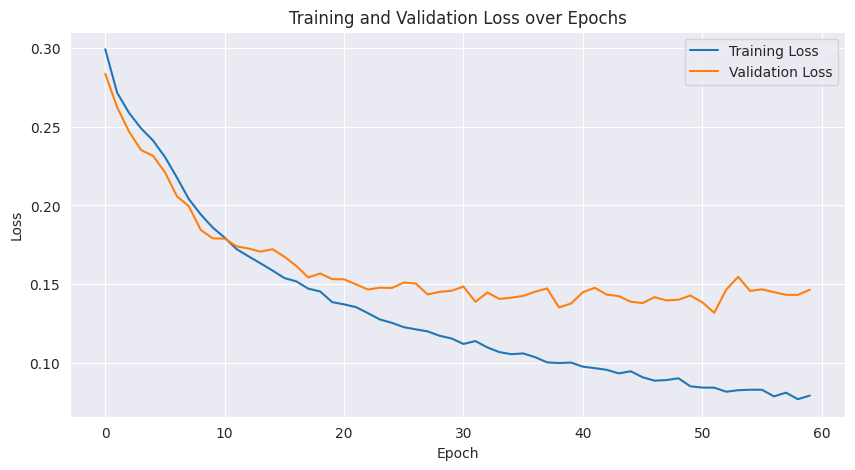

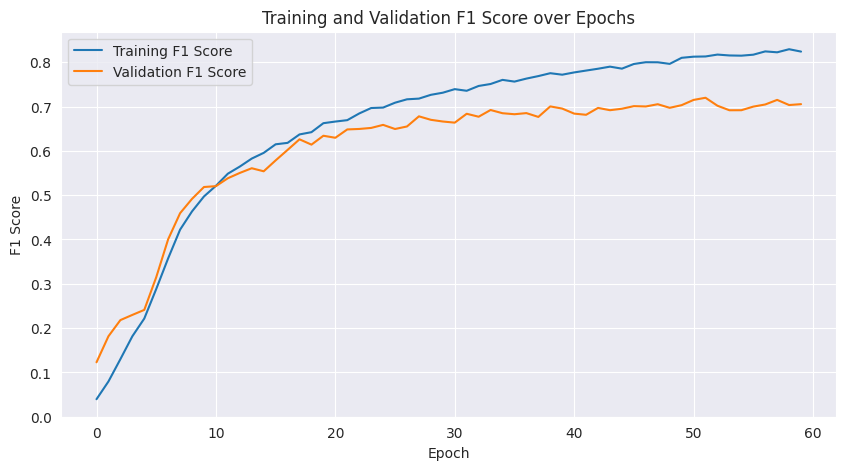

In [10]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation F1 Score
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label='Training F1 Score')
plt.plot(val_f1_scores, label='Validation F1 Score')
plt.title('Training and Validation F1 Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

## Model Evalation

### Testset

In [26]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import librosa
import os
import logging

class IRMASTestDataset(Dataset):
    def __init__(self, file_paths, labels, label_encoder,
                 mel_specs_dir,
                 additional_features_dir,
                 scaler,
                 target_sr=22050,
                 n_fft=1024,
                 hop_length=512,
                 n_mels=128,
                 window_size=3.0,
                 hop_size=None,
                 transform=None):
        """
        Dataset for test audio files with variable lengths and overlapping windows.

        Args:
            file_paths (list): List of test audio file paths.
            labels (list): List of labels (list of instruments) for each file.
            label_encoder (LabelEncoder): Fitted LabelEncoder.
            mel_specs_dir (str): Directory where precomputed mel-spectrograms are stored.
            additional_features_dir (str): Directory where additional features are stored.
            scaler (StandardScaler): Fitted scaler for additional features.
            target_sr (int): Target sampling rate.
            n_fft (int): Number of FFT components.
            hop_length (int): Number of samples between successive frames.
            n_mels (int): Number of Mel bands.
            window_size (float): Window size in seconds (same as training window).
            hop_size (float): Hop size in seconds (half of window size if None).
            transform (callable): Optional transform to be applied on a sample.
        """
        self.file_paths = file_paths
        self.labels = labels
        self.label_encoder = label_encoder
        self.mel_specs_dir = mel_specs_dir
        self.additional_features_dir = additional_features_dir
        self.scaler = scaler
        self.target_sr = target_sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.window_size = window_size
        self.hop_size = hop_size if hop_size is not None else window_size / 2
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def get_additional_feat_path(self, audio_path):
        # Get the relative path from the data directory
        relative_path = os.path.relpath(audio_path, start=os.path.commonpath(self.file_paths))
        # Construct the path to the additional features
        additional_feat_path = os.path.join(self.additional_features_dir, relative_path) + '_features.npy'
        return additional_feat_path

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        labels = self.labels[idx]

        # Load the audio file
        y, sr = librosa.load(file_path, sr=self.target_sr, mono=True)

        # Normalize the audio signal
        if np.max(np.abs(y)) > 0:
            y = y / np.max(np.abs(y))

        # Calculate the number of samples per window and hop
        window_length_samples = int(self.window_size * self.target_sr)
        hop_length_samples = int(self.hop_size * self.target_sr)

        # Compute the number of windows
        total_length = len(y)
        num_windows = int(np.ceil((total_length - window_length_samples) / hop_length_samples)) + 1

        # Segment the audio into overlapping windows
        segments = []
        for i in range(num_windows):
            start = i * hop_length_samples
            end = start + window_length_samples
            segment = y[start:end]

            # Pad segment if necessary
            if len(segment) < window_length_samples:
                pad_width = window_length_samples - len(segment)
                segment = np.pad(segment, (0, pad_width), mode='constant')

            # Compute mel-spectrogram
            mel_spec = librosa.feature.melspectrogram(
                y=segment,
                sr=self.target_sr,
                n_fft=self.n_fft,
                hop_length=self.hop_length,
                n_mels=self.n_mels,
                fmax=self.target_sr / 2
            )
            # Apply logarithm
            mel_spec = np.log(mel_spec + 1e-9)
            segments.append(mel_spec)

        # Convert list of segments to a tensor
        segments = np.array(segments)  # Shape: [num_windows, n_mels, time_frames]
        segments = torch.tensor(segments, dtype=torch.float32)

        # Add channel dimension
        segments = segments.unsqueeze(1)  # Shape: [num_windows, 1, n_mels, time_frames]

        # Apply transformations if any
        if self.transform:
            segments = self.transform(segments)

        # Load additional features
        additional_feat_path = self.get_additional_feat_path(file_path)
        if os.path.exists(additional_feat_path):
            additional_features = np.load(additional_feat_path)
        else:
            # Handle missing additional features files
            logging.warning(f"Additional features not found at {additional_feat_path}. Using zeros.")
            additional_features = np.zeros(10)  # Assuming 10 additional features

        # Apply scaling if scaler is provided
        if self.scaler:
            additional_features = self.scaler.transform(additional_features.reshape(1, -1)).flatten()

        # Repeat additional_features for each segment
        additional_features = np.tile(additional_features, (num_windows, 1))  # Shape: [num_windows, 10]
        additional_features = torch.tensor(additional_features, dtype=torch.float32)

        # Convert labels to multi-hot encoding
        if labels:  # If labels list is not empty
            label_indices = self.label_encoder.transform(labels)
            target = torch.zeros(len(self.label_encoder.classes_), dtype=torch.float32)
            target[label_indices] = 1.0
        else:
            # Assign all zeros if no labels are present
            target = torch.zeros(len(self.label_encoder.classes_), dtype=torch.float32)

        return (segments, additional_features), target, file_path  # Return file_path for identification

# Refit label encoder to fix bug for [unknown] label in test dataset

from sklearn.preprocessing import LabelEncoder

# Collect all unique labels from training and testing (excluding 'unknown')
all_labels = set(label for sublist in train_labels + test_labels for label in sublist if label != "unknown")
label_encoder = LabelEncoder()
label_encoder.fit(list(all_labels))

# Save the encoder
import pickle
with open("nn_label_encoder.pkl", "wb") as file:
    pickle.dump(label_encoder, file)

### Model Prediction


In [29]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from sklearn.metrics import (f1_score, multilabel_confusion_matrix,
                             ConfusionMatrixDisplay, precision_recall_fscore_support,
                             accuracy_score, hamming_loss)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

# -------------------------------
# 1. Load Label Encoder and Scaler
# -------------------------------

# Load the LabelEncoder and Scaler
with open("nn_label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

with open("additional_features_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# -------------------------------
# 2. Instantiate the DualInputModel
# -------------------------------

# Instantiate the DualInputModel
num_classes = len(label_encoder.classes_)
model = DualInputModel(num_classes=num_classes)

# Load the best model weights
model.load_state_dict(torch.load('best_dual_input_model.pth'))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# -------------------------------
# 3. Instantiate the Test Dataset and DataLoader
# -------------------------------

# Define directories for precomputed mel-spectrograms and additional features
mel_specs_dir = './preprocessed_data_mel_spectrogram'  # Update as per your directory structure
additional_features_dir = './preprocessed_data_additional_features'  # Update as per your directory structure

# Instantiate the test dataset and DataLoader
test_dataset = IRMASTestDataset(
    file_paths=test_file_paths,
    labels=test_labels,
    label_encoder=label_encoder,
    mel_specs_dir=mel_specs_dir,
    additional_features_dir=additional_features_dir,
    scaler=scaler,
    target_sr=22050,
    n_fft=1024,
    hop_length=512,
    n_mels=128,
    window_size=3.0,  # Same as training window size
    hop_size=1.5,     # Half of the window size
    transform=None
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,  # Batch size of 1 since each item may have different number of segments
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# -------------------------------
# 4. Define Thresholds for Prediction
# -------------------------------

# Define thresholds to evaluate
thresholds = np.linspace(0.2, 0.8, 13)
best_f1 = 0.0
best_threshold = 0.5
f1_scores = []

# Store true labels and predicted labels for all thresholds
all_true_labels = []
all_predicted_labels = {threshold: [] for threshold in thresholds}

# -------------------------------
# 5. Testing Loop
# -------------------------------

# Define thresholds to evaluate
thresholds = np.linspace(0.2, 0.8, 13)
best_f1 = 0.0
best_threshold = 0.5
f1_scores = []

# Initialize storage for true labels and predictions
all_true_labels = []
all_predicted_labels = {threshold: [] for threshold in thresholds}

# Testing loop
for (segments, additional_features), target, file_path in tqdm(test_loader, desc='Testing'):
    segments = segments.squeeze(0)  # Shape: [num_segments, 1, n_mels, time_frames]
    additional_features = additional_features.squeeze(0)  # Shape: [num_segments, 10]
    target = target.squeeze(0).cpu().numpy()  # Shape: [num_classes]
    file_path = file_path[0]  # Get the string from list

    num_segments = segments.size(0)
    segments = segments.to(device)  # [num_segments, 1, n_mels, time_frames]
    additional_features = additional_features.to(device)  # [num_segments, 10]

    # Forward pass for all segments
    with torch.no_grad():
        outputs = model(segments, additional_features)  # [num_segments, num_classes]
        probabilities = torch.sigmoid(outputs).cpu().numpy()  # [num_segments, num_classes]

    # Aggregate predictions by averaging class-wise
    avg_probabilities = np.mean(probabilities, axis=0)  # [num_classes]

    # Normalize by dividing by the maximum value among classes to avoid scaling issues
    if np.max(avg_probabilities) > 0:
        normalized_probs = avg_probabilities / np.max(avg_probabilities)
    else:
        normalized_probs = avg_probabilities

    # Store true labels
    all_true_labels.append(target)

    # Apply different thresholds and store predictions
    for threshold in thresholds:
        predicted_labels = (normalized_probs >= threshold).astype(int)
        all_predicted_labels[threshold].append(predicted_labels)



Testing: 100%|██████████| 2108/2108 [05:02<00:00,  6.98it/s]


Threshold: 0.20, F1 Score: 0.4989
Threshold: 0.25, F1 Score: 0.5223
Threshold: 0.30, F1 Score: 0.5345
Threshold: 0.35, F1 Score: 0.5411
Threshold: 0.40, F1 Score: 0.5447
Threshold: 0.45, F1 Score: 0.5460
Threshold: 0.50, F1 Score: 0.5467
Threshold: 0.55, F1 Score: 0.5438
Threshold: 0.60, F1 Score: 0.5404
Threshold: 0.65, F1 Score: 0.5335
Threshold: 0.70, F1 Score: 0.5261
Threshold: 0.75, F1 Score: 0.5227
Threshold: 0.80, F1 Score: 0.5191

Best Threshold: 0.50, Best F1 Score: 0.5467
Class: cel
  Precision: 0.1818
  Recall:    0.1099
  F1 Score:  0.1370
  Confusion Matrix:
[[1972   45]
 [  81   10]]

Class: cla
  Precision: 0.0417
  Recall:    0.0882
  F1 Score:  0.0566
  Confusion Matrix:
[[2005   69]
 [  31    3]]

Class: flu
  Precision: 0.9273
  Recall:    0.4435
  F1 Score:  0.6000
  Confusion Matrix:
[[1989    4]
 [  64   51]]

Class: gac
  Precision: 0.7684
  Recall:    0.3523
  F1 Score:  0.4831
  Confusion Matrix:
[[1681   41]
 [ 250  136]]

Class: gel
  Precision: 0.5518
  Reca

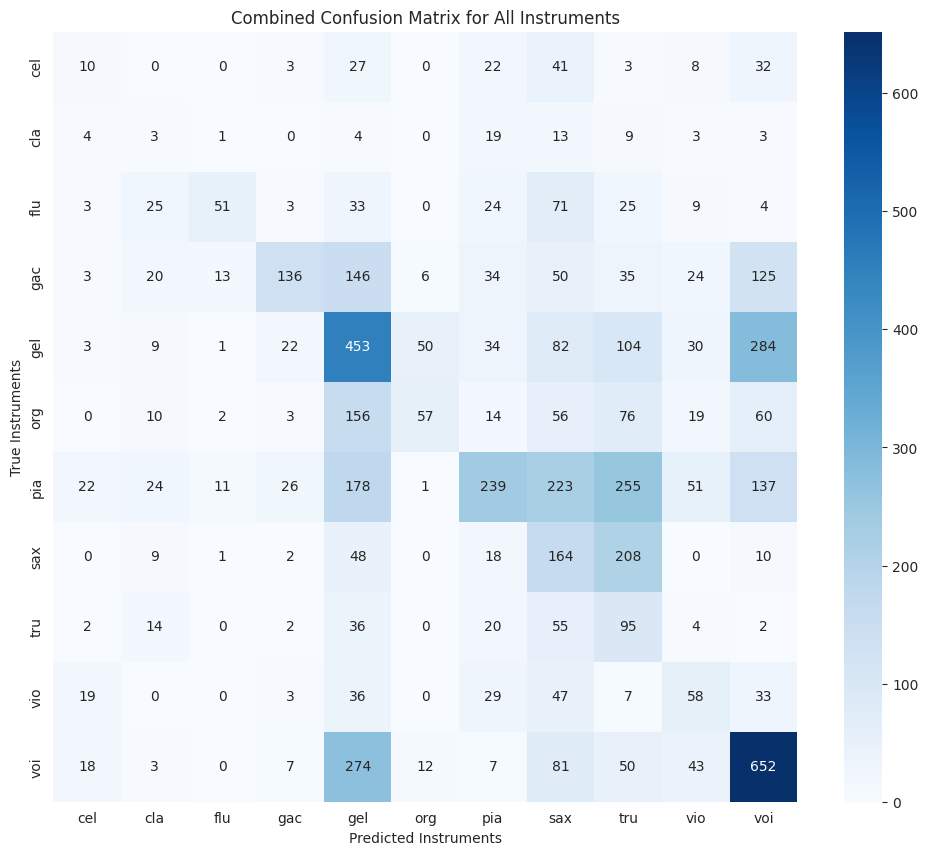

In [33]:
# Convert lists to numpy arrays for metric computation
all_true_labels = np.array(all_true_labels)  # Shape: [num_files, num_classes]


# -------------------------------
# 6. Compute F1 Scores for Each Threshold
# -------------------------------

for threshold in thresholds:
    preds = np.array(all_predicted_labels[threshold])  # Shape: [num_files, num_classes]
    f1 = f1_score(all_true_labels, preds, average='micro', zero_division=0)
    f1_scores.append(f1)
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_preds = preds

print(f"\nBest Threshold: {best_threshold:.2f}, Best F1 Score: {best_f1:.4f}")

# -------------------------------
# 7. Compute and Display Confusion Matrices for the Best Threshold
# -------------------------------

# Compute confusion matrices for the best threshold
confusion_matrices = multilabel_confusion_matrix(all_true_labels, best_preds)

# Display confusion matrices and metrics for each class
class_labels = label_encoder.classes_

# Compute class-wise precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(
    all_true_labels,
    best_preds,
    average=None,
    zero_division=0
)

for idx, (cm, label) in enumerate(zip(confusion_matrices, class_labels)):
    print(f"Class: {label}")
    print(f"  Precision: {precision[idx]:.4f}")
    print(f"  Recall:    {recall[idx]:.4f}")
    print(f"  F1 Score:  {f1[idx]:.4f}")
    print(f"  Confusion Matrix:\n{cm}\n")

    # Optionally display confusion matrix as a plot
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Not {label}', label])
    #disp.plot(values_format='d')
    #plt.title(f'Confusion Matrix for Class: {label}')
    #plt.show()

# -------------------------------
# 8. Compute Overall Metrics
# -------------------------------

# Calculate Exact Match Accuracy (Subset Accuracy)
exact_match_accuracy = accuracy_score(all_true_labels, best_preds)
print(f"Exact Match Accuracy (Subset Accuracy): {exact_match_accuracy:.4f}")

# Calculate Hamming Loss and Hamming Accuracy
hamming_loss_value = hamming_loss(all_true_labels, best_preds)
hamming_accuracy = 1 - hamming_loss_value
print(f"Hamming Accuracy: {hamming_accuracy:.4f}")

# -------------------------------
# 9. Plot F1 Score vs Threshold
# -------------------------------

# Plot F1 Score vs Threshold
#plt.figure(figsize=(8, 6))
#plt.plot(thresholds, f1_scores, marker='o')
#plt.title('F1 Score vs Threshold')
#plt.xlabel('Threshold')
#plt.ylabel('F1 Score')
#plt.grid(True)
#plt.show()

# -------------------------------
# 10. Compute and Display Combined Confusion Matrix
# -------------------------------

# Compute the combined confusion matrix
num_classes = all_true_labels.shape[1]
combined_confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

for true_labels, predicted_labels in zip(all_true_labels, best_preds):
    true_indices = np.where(true_labels == 1)[0]
    pred_indices = np.where(predicted_labels == 1)[0]
    for i in true_indices:
        for j in pred_indices:
            combined_confusion_matrix[i][j] += 1

# Display the combined confusion matrix
confusion_df = pd.DataFrame(combined_confusion_matrix, index=class_labels, columns=class_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues')
plt.title('Combined Confusion Matrix for All Instruments')
plt.xlabel('Predicted Instruments')
plt.ylabel('True Instruments')
plt.show()

### Single Hit Accuracy

In [1]:
# Compute element-wise logical AND to find correctly predicted labels
correct_predictions = np.logical_and(all_true_labels, best_preds)  # Shape: [2108, 11]

# Sum the correctly predicted labels per sample
num_correct_labels_per_sample = correct_predictions.sum(axis=1)  # Shape: [2108]

# Count samples with exactly one correctly predicted label
num_single_label_matches = np.sum(num_correct_labels_per_sample == 1)

# Calculate Single Label Match Accuracy
single_label_match_accuracy = num_single_label_matches / all_true_labels.shape[0]

print(f"Single Label Match Accuracy: {single_label_match_accuracy:.4f}")

NameError: name 'np' is not defined